# Decision trees

Principle : Imagine you want to distinguish between the following four animals: bears, hawks, penguins, and dolphins. Your goal is to get to the right answer by asking as few if/else questions as possible. You might start off by asking whether the animal has feathers, a question that narrows down your possible animals to just two. If the answer is “yes,” you can ask another question that could help you distinguish between hawks and penguins. For example, you could ask whether the animal can fly. If the animal doesn’t have feathers, your possible animal choices are dolphins and bears, and you will need to ask a question to distinguish between these two animals—for example, asking whether the animal has fins.

In [28]:
%load_ext autoreload
%autoreload
from LinearModels import display_plot_logreg, display_plot_svc
from utils import feature_selection, thomas_parser, PCA_reduction, perf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from tabulate import tabulate
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First test

In [5]:
gt = pd.read_csv('../dumps/2020.01.13-14.25.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

tree = DecisionTreeClassifier(random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.759


The presence of pure leaves mean that a tree is 100% accurate on the training set; each data point in the training set is in a leaf that has the correct majority class. This is exactly what we can see from this result. We clearly fall into the trap of overfitting, meaning that this case is quite bad at generalization. This might be avoided by using two different strategies : *pre-pruning*, which will stop the creation of the tree before reaching the pure leaves, or *post-pruning*, which consists in collapsing or removing nodes with small information after the complete creation. For the first one, it can be done by limiting the depth, the number of leaves or either fixing a minimum number of nodes.

### Further tests

Let's now carry on with a bigger dataset and try with different values of the parameters.

In [2]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

#### Depth

Limiting the depth of the tree decreases overfitting. This leads to a lower accuracy on the training set, but an improvement on the test set:

In [3]:
for i in range(1,10):
    print("Depth set to %s" % i)
    tree = DecisionTreeClassifier(max_depth=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Depth set to 1
Accuracy on training set: 0.895
Accuracy on test set: 0.900
Depth set to 2
Accuracy on training set: 0.912
Accuracy on test set: 0.915
Depth set to 3
Accuracy on training set: 0.918
Accuracy on test set: 0.915
Depth set to 4
Accuracy on training set: 0.924
Accuracy on test set: 0.923
Depth set to 5
Accuracy on training set: 0.930
Accuracy on test set: 0.919
Depth set to 6
Accuracy on training set: 0.935
Accuracy on test set: 0.917
Depth set to 7
Accuracy on training set: 0.941
Accuracy on test set: 0.911
Depth set to 8
Accuracy on training set: 0.945
Accuracy on test set: 0.911
Depth set to 9
Accuracy on training set: 0.951
Accuracy on test set: 0.908


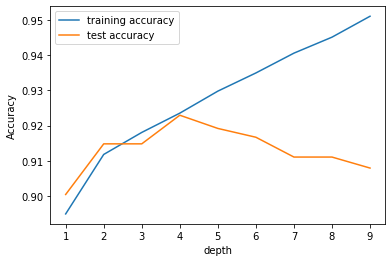

In [5]:
training_accuracy = [] 
test_accuracy = []
settings = range(1, 10)
for v in settings:
    clf = DecisionTreeClassifier(max_depth=v, random_state=0) 
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("depth")
plt.legend()

As we can see, increasing the depth value improves the accuracy of the training set but not necessarily of the test set. The best result we get at depth 4, which offers a good compromise between the two accuracies.

#### Minimum number of samples (split)

*min_samples_split* represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node.

In [36]:
for i in range(1,11):
    n_samples = i/10
    print("min_samples_split set to %s" % n_samples)
    tree = DecisionTreeClassifier(min_samples_split=n_samples, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

min_samples_split set to 0.1
Accuracy on training set: 0.915
Accuracy on test set: 0.898
min_samples_split set to 0.2
Accuracy on training set: 0.896
Accuracy on test set: 0.886
min_samples_split set to 0.3
Accuracy on training set: 0.895
Accuracy on test set: 0.898
min_samples_split set to 0.4
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 0.5
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 0.6
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 0.7
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 0.8
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 0.9
Accuracy on training set: 0.895
Accuracy on test set: 0.900
min_samples_split set to 1.0
Accuracy on training set: 0.895
Accuracy on test set: 0.900


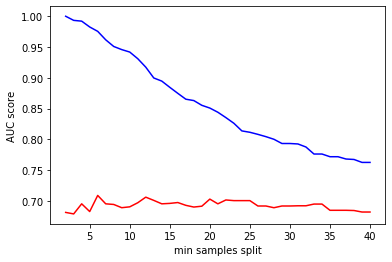

In [22]:
min_samples_splits = range(2,41)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=0)
   dt.fit(data_train, target_train)
   train_pred = dt.predict(data_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(data_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

In [21]:
for i in range(2,11):
    print("min_samples_split set to %s" % i)
    tree = DecisionTreeClassifier(min_samples_split=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

min_samples_split set to 2
Accuracy on training set: 1.000
Accuracy on test set: 0.869
min_samples_split set to 3
Accuracy on training set: 0.999
Accuracy on test set: 0.870
min_samples_split set to 4
Accuracy on training set: 0.997
Accuracy on test set: 0.879
min_samples_split set to 5
Accuracy on training set: 0.995
Accuracy on test set: 0.872
min_samples_split set to 6
Accuracy on training set: 0.991
Accuracy on test set: 0.878
min_samples_split set to 7
Accuracy on training set: 0.988
Accuracy on test set: 0.879
min_samples_split set to 8
Accuracy on training set: 0.984
Accuracy on test set: 0.872
min_samples_split set to 9
Accuracy on training set: 0.982
Accuracy on test set: 0.883
min_samples_split set to 10
Accuracy on training set: 0.981
Accuracy on test set: 0.880


#### Minimum number of samples (leaf)

*min_samples_leaf* is the minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples at the leafs, the base of the tree.

In [31]:
for i in range(2,11):
    print("min_samples_split set to %s" % i)
    tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

min_samples_split set to 2
Accuracy on training set: 0.986
Accuracy on test set: 0.885
min_samples_split set to 3
Accuracy on training set: 0.978
Accuracy on test set: 0.876
min_samples_split set to 4
Accuracy on training set: 0.971
Accuracy on test set: 0.881
min_samples_split set to 5
Accuracy on training set: 0.966
Accuracy on test set: 0.885
min_samples_split set to 6
Accuracy on training set: 0.962
Accuracy on test set: 0.885
min_samples_split set to 7
Accuracy on training set: 0.953
Accuracy on test set: 0.887
min_samples_split set to 8
Accuracy on training set: 0.948
Accuracy on test set: 0.887
min_samples_split set to 9
Accuracy on training set: 0.945
Accuracy on test set: 0.883
min_samples_split set to 10
Accuracy on training set: 0.941
Accuracy on test set: 0.899


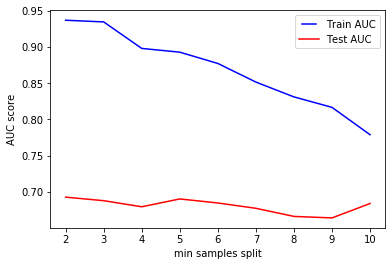

In [6]:
settings = range(2,11)
train_results = []
test_results = []
for v in settings:
   dt = DecisionTreeClassifier(min_samples_leaf=v, random_state=0)
   dt.fit(data_train, target_train)
   train_pred = dt.predict(data_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(data_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(settings, train_results, 'b', label="Train AUC")
line2, = plt.plot(settings, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

#### Number of features

*max_features* represents the number of features to consider when looking for the best split. Since we're working with 119 different features, let's try all the values and see how relevant they are.

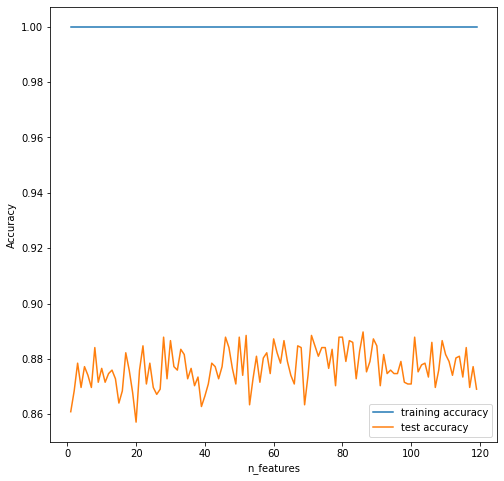

In [35]:
training_accuracy = [] 
test_accuracy = []
settings = range(1, 120)
for f in settings:
    clf = DecisionTreeClassifier(max_features=f, random_state=0) #n_jobs means that we use all processors
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_features")
plt.legend()

As we can see from the graph, not all features are important in making the classification. Further selection on relevant features will be made.

### Best match

In [12]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

In [ ]:
parameters = {'max_depth': np.arange(1,11), 'min_samples_split': np.arange(1,21), 'min_samples_leaf': np.arange(1,11), 'max_features': np.arange(1,120)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

In [ ]:
parameters = {'max_depth': np.arange(1,11), 'min_samples_split': np.arange(1,21), 'min_samples_leaf': np.arange(1,11), 'max_features': np.arange(1,120)}
clf = RandomizedSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

In [13]:
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.913
Accuracy on test set: 0.910


### Comparison between different kind of datasets

Let's first see performances on a default dataset, which means a threshold of 3/5 detectors, a limit of 8000 malwares,  all features considered, all detectors considered and errors understood as non-packed result.

In [22]:
gt = pd.read_csv('../dumps/control_8000_false_3.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.945
Accuracy on test set: 0.945


#### Different thresholds

In [18]:
gt = pd.read_csv('../dumps/default_1.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.943
Accuracy on test set: 0.946


In [19]:
gt = pd.read_csv('../dumps/default_2.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.980
Accuracy on test set: 0.982


In [20]:
gt = pd.read_csv('../dumps/default_4.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.963
Accuracy on test set: 0.965


In [21]:
gt = pd.read_csv('../dumps/default_5.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.963
Accuracy on test set: 0.965


#### Errors considered as positive result from detector

In [17]:
gt = pd.read_csv('../dumps/error_as_packed.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.980
Accuracy on test set: 0.982


#### Check influence of each detector

In [23]:
gt = pd.read_csv('../dumps/not_die.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.971
Accuracy on test set: 0.977


In [24]:
gt = pd.read_csv('../dumps/not_cisco.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.978
Accuracy on test set: 0.976


In [25]:
gt = pd.read_csv('../dumps/not_manalyze.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.963
Accuracy on test set: 0.965


In [26]:
gt = pd.read_csv('../dumps/not_peid.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.962
Accuracy on test set: 0.965


In [27]:
gt = pd.read_csv('../dumps/not_peframe.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)
tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.963
Accuracy on test set: 0.966


### Features relevance

In [9]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

The following commands allow us to see how important each feature is in the decision process.

In [12]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04065378 0.01724961 0.
 0.         0.08984802 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.04027522 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.03249722 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0

Text(0, 0.5, 'Feature')

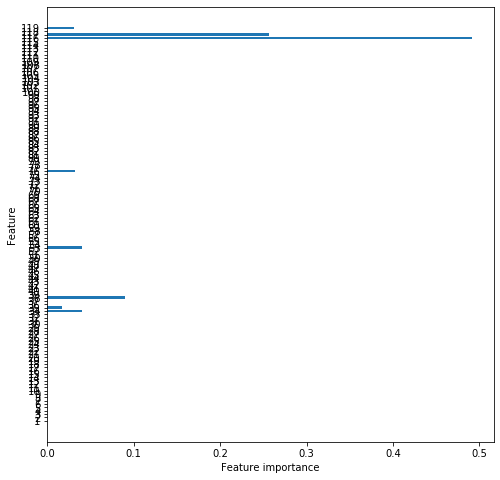

In [11]:
n_features = data.shape[1]
plt.rcParams["figure.figsize"] = (8,8)
plt.barh(range(n_features), tree.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), np.arange(1,120)) 
plt.xlabel("Feature importance")
plt.ylabel("Feature")

As we can see, out of 119 features only a very few are actually used by the learning algorithm. Let's apply some pruning on the features to see if it improves the accuracies (or even the speed of the process).

0.15
(1196, 119)
(1196, 7)
0.3
(2393, 119)
(2393, 7)
3
0.44999999999999996
(3589, 119)
(3589, 7)
2
0.6
(4786, 119)
(4786, 8)
2
0.75
(5982, 119)
(5982, 8)
2
0.9
(7179, 119)
(7179, 8)
2


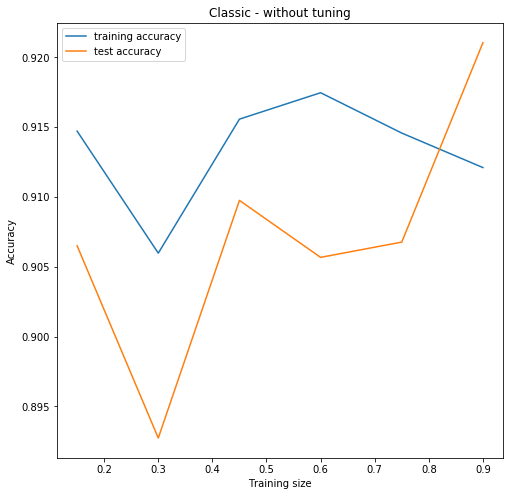

Training max value : 0.9174676138737986
Test max value : 0.9210526315789473


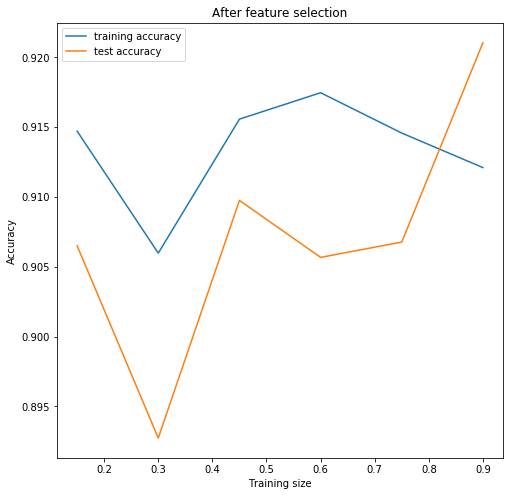

Training max value : 0.9174676138737986
Test max value : 0.9210526315789473


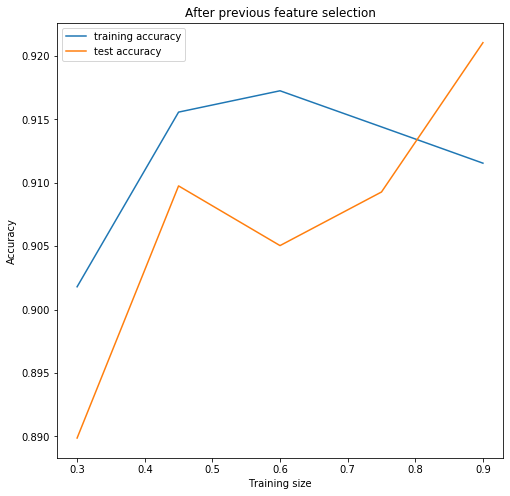

Training max value : 0.917258671124112
Test max value : 0.9210526315789473


In [13]:
feature_selection('../dumps/2020.02.10-12.14.csv',0.15,"tree")

It's quite intuitive to see that there's no difference between the two first situations. Indeed, since not a lot of features are used anyway, doing a feature selection doesn't improve the accuracies. What is interesting to see is that on the last graph, the number of features used is even lower (between 2 and 3) but the results are nearly the same, which that just a few features are doing most of the job.

Let's see if the performance can be improved when using a larger dataset which is nearly twice the size of the previous one (14703 entries).

In [7]:
feature_selection('../dumps/2020.03.11-17.39.csv',0.15,"tree")

0.15
(2205, 119)
(2205, 6)
0.3
(4410, 119)
(4410, 6)
4
0.44999999999999996
(6616, 119)
(6616, 6)
3
0.6
(8821, 119)
(8821, 5)
0
0.75
(11027, 119)
(11027, 6)


ValueError: at least one array or dtype is required

We suffer the issue of not having enough features between the iterations to create an intersect with more than one value in common. Let's just see how it goes without the intersect.

0.15
(2205, 119)
(2205, 6)
0.3
(4410, 119)
(4410, 6)
0.44999999999999996
(6616, 119)
(6616, 6)
0.6
(8821, 119)
(8821, 5)
0.75
(11027, 119)
(11027, 6)
0.9
(13232, 119)
(13232, 6)


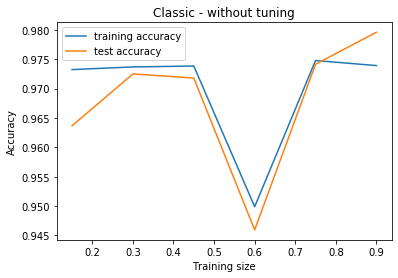

Training max value : 0.974789153894985
Test max value : 0.9796057104010877


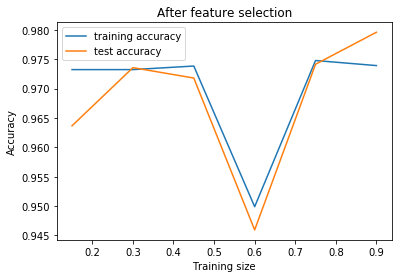

Training max value : 0.974789153894985
Test max value : 0.9796057104010877


In [14]:
feature_selection('../dumps/2020.03.11-17.39.csv',0.15,"tree")

What shows up straight away is that by simply doubling the size of the dataset we went from a pure test accuracy of 0.92 up to 0.979 (with 90% training set), this is quite impressive ! We can also notice that there's no difference between the results we get with and without the feature extraction, which mean that the model could definittely be simplified to a few features. One last thing we can also observe is that we suffer from a huge drop when setting a value of 0.6 for the training set, which I cannot explain.

### Test with Thomas datasets

In [6]:
gt = pd.read_csv(thomas_parser("../dumps/2019-08.Merged"))
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

tree = DecisionTreeClassifier(max_depth=4,min_samples_split=0.1,min_samples_leaf=10,random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.885
Accuracy on test set: 0.883


### PCA

In [14]:
PCA_reduction('../dumps/2020.03.11-17.39.csv','tree')

  Variance    Training acc    Test acc    Components    Time (s)
----------  --------------  ----------  ------------  ----------
      1           0.950859    0.946957           119    0.572946
      0.99        0.950859    0.946957            98    0.504874
      0.95        0.950859    0.946957            77    0.405857
      0.9         0.950859    0.946957            60    0.339165
      0.85        0.950859    0.946957            47    0.28785


In this case the accuracies are 100% similar but we managed to reduced the number of features from 119 to 47, so more than 60%. The time as also be improved by half !

In [ ]:
plt.matshow(pca.components_, cmap='viridis') 
plt.yticks([0, 1], ["First component", "Second component"]) 
plt.colorbar() 
plt.xticks(range(len(cancer.feature_names)),
cancer.feature_names, rotation=60, ha='left') 
plt.xlabel("Feature")
plt.ylabel("Principal components")